In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.transforms import v2 
import matplotlib.pyplot as plt
import numpy as np

from datasets import load_dataset, Image
from tqdm import trange

from utils import *
import os

# ----------
device = 'mps:0'
latent_dim = 2
beta = 0.2


##### initialize data

train_data = load_dataset("mnist", split='train')
test_data = load_dataset("mnist", split='test')



In [3]:
from VAE import *
model = VAE(latent_dim, beta)
model.to(device)
run_name = 'mnist2d'

##### initialize VAE

weights_path = os.path.join('weights',run_name, "ckpt.pt")
if os.path.exists(weights_path):
    model.load_state_dict(torch.load(weights_path, weights_only=True))
    print("Successfully loaded saved weights")


Successfully loaded saved weights


In [4]:
#Training 
#TODO: noising

epochs = 100
batch_size = 128
learn_rate = 1e-5

def train(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate)
    train_dataloader = DataLoaderLite(train_data)
    test_dataloader = DataLoaderLite(test_data)

    for epoch in range(epochs):
        steps = train_dataloader.len // batch_size
        train_loss_accum = 0
        for _ in trange(steps):
            images, labels = train_dataloader.get_Batch(batch_size)
            imgs = images.to(device)
            # TODO labels

            model.train()
            optimizer.zero_grad()
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                _, loss = model(imgs)
            loss.backward()
            optimizer.step()
            train_loss_accum += loss.detach()

        avg_train_loss = train_loss_accum / steps

        # Every epoch evaluate val loss (4 batches)
        model.eval()
        with torch.no_grad():
            val_images, val_labels = test_dataloader.get_Batch(batch_size)
            val_imgs = val_images.to(device)

            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                _, loss = model(val_imgs)
            loss = loss.detach()
            print(f"Epoch: {epoch}, train loss: {avg_train_loss}, val loss: {loss}")
        model.train()
        torch.save(model.state_dict(), os.path.join("weights",run_name, f"ckpt.pt"))



In [ ]:
tot = 0   #437880
for p in model.parameters():
    tot += p.numel()
print(f"total parameters: {tot}") 

train(model)



total parameters: 435988


 66%|██████▌   | 307/468 [00:06<00:02, 79.68it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x103fdd070>>
Traceback (most recent call last):
  File "/Users/alexxu/Desktop/Folder/ML/base/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 794, in _clean_thread_parent_frames
    for identity in list(thread_to_parent_header.keys()):
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt: 
100%|██████████| 468/468 [00:08<00:00, 55.33it/s]


Epoch: 0, train loss: 0.04405507072806358, val loss: 0.04222499579191208


  2%|▏         | 8/468 [00:00<00:05, 77.81it/s]

<class 'list'> <class 'list'>


100%|██████████| 468/468 [00:06<00:00, 73.91it/s]


Epoch: 1, train loss: 0.04404332488775253, val loss: 0.04183747619390488


  2%|▏         | 8/468 [00:00<00:06, 75.99it/s]

<class 'list'> <class 'list'>


 46%|████▌     | 215/468 [00:03<00:03, 72.03it/s]

0: MSE loss 0.05804555118083954
1: MSE loss 0.031164415180683136
2: MSE loss 0.05029366910457611
3: MSE loss 0.02954462543129921
4: MSE loss 0.05923551321029663
5: MSE loss 0.033519092947244644
6: MSE loss 0.028801003471016884
7: MSE loss 0.007158657535910606
means: tensor([[-0.2893, -0.0548],
        [-0.5396, -0.7458],
        [-0.5292,  0.2345],
        [ 0.4445, -1.5774],
        [ 1.4797,  0.4506],
        [ 0.2108,  1.2285],
        [ 0.1930, -1.2548],
        [-0.8437, -2.8651]], device='mps:0', grad_fn=<SplitWithSizesBackward0>), log stds: tensor([[-3.4828, -3.3422],
        [-3.3594, -3.0623],
        [-3.2243, -3.1915],
        [-3.1013, -2.8961],
        [-3.3830, -3.3709],
        [-3.5399, -3.2081],
        [-3.4230, -3.1309],
        [-2.9021, -1.9456]], device='mps:0', grad_fn=<SplitWithSizesBackward0>)


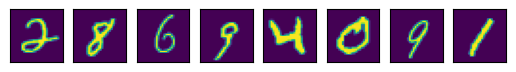

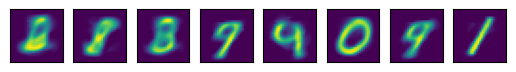

In [ ]:
# Test to see model outputs
loader = DataLoaderLite(train_data)

images, labels = loader.get_Batch(8)

bef, aft = sample(model, images)
for i in range(8):
    loss = F.mse_loss(bef[i], aft[i])
    print(f"{i}: MSE loss {loss}")

images = images.to(device)
x, loss = model(images,debug = True) #A flag to see the means/logstds

bef = dec(bef)
aft = dec(aft)
show([bef[i] for i in range(len(bef))])
show([aft[i] for i in range(len(aft))])
